# Laser Electron Accelerator

T. Tajima and J. M. Dawson

_Department of Physics, University of California, Los Angeles, California 90024_

Physical Review Letters, Volume 43, NUmber 4, July 1979

[DOI: 10.1103/PhysRevLett.43.267](https://doi.org/10.1103/PhysRevLett.43.267)

In this notebook we look at the 1D simulations presented by Tajima and Dawson in their seminal paper of 1979. In this paper they explore the acceleration of electrons through laser plasma acceleration.

## Original simulations

The original paper uses a 1D-3V relativistic electromagnetic code based on a spectral solver with gaussian shaped particles which is described in more detail in this paper: The Physics of Fluids 17, 1995 (1974) [DOI:10.1063/1.1694656](https://doi.org/10.1063/1.1694656). 

The parameters used below reproduce the ones used for figure 1 with $ c = 10 \, \omega_p \Delta $. It should be noted that we are using simple periodic boundaries, and as a result some particles are pushed backwards by the pump wave and end up recirculating and reentering from the front of the simulation box. This effect can be avoided just by setting x0 (the start of the driver pulse) to a larger value (e.g. $150 \Delta$).

We do a small adjustment to the kx parameter setting so that the pump wave has exactly 2 wavelengths, thus avoiding a sharp cutoff at the front of the wave. This lowers the wave frequency from $ \omega / \omega_p = 4.3 $ to $4.12$.

Finally, since ZPIC uses linear interpolation and the original code used gaussian shaped particles, we also use current smoothing to get less noisy wakefields.

In [1]:
# Add zpic library to path
import sys
sys.path.append("../../lib")

import em1d as zpic
import numpy as np
import matplotlib.pyplot as plt


uth = [0.2, 0.2, 0.2 ]
electrons = zpic.Species( "electrons", -1.0, 10, uth = uth )

dx = 0.1
Lx = 512 * dx

dt = 0.99 * dx

nx = Lx/dx

sim = zpic.Simulation( nx, box = Lx, dt = dt, species = electrons )
sim.set_smooth( zpic.Smooth(xtype = "compensated", xlevel = 4) )

x0 = 50 * dx
width = 10 * np.pi * dx

# Original value
# kx = 2 * np.pi / (15 * dx)

# Corrected value - 2 cicles
kx = 4 * np.pi / width

omega = np.sqrt(1+ kx**2)
E0 = omega

print("omega = {:5.2f}".format(omega))


omega =  4.12


The initial pump waves have the form $E_y=E_0 \sin k_x(x -x_0)$, $B_z=B_0 \sin k_x(x -x0)$. We can set these using the "InitialFields" object with custom functions:

In [2]:
def bz0( ix, dx ):
    # Bz is located at the center of the cell
    x = (ix+0.5)*dx
    if ( x > x0 ) and (x < (x0+width)):
        fld = E0*np.sin( kx * ( x - x0 ) )
    else:
        fld = 0

    return [0,0,fld ]

def ey0( ix, dx ):
    # Ey is located at the corner of the cell
    x = ix * dx
    if ( x > x0 ) and ( x < (x0 + width)):
        fld = E0*np.sin( kx * ( x - x0 ) )
    else:
        fld = 0

    return [0, fld, 0 ]


init = zpic.InitialField(B_type = 'custom', B_custom = bz0,
                        E_type = 'custom', E_custom = ey0)

sim.emf.init_fld( init )

The original paper also sets the transverse (y) momentum of the particles lying in the pump wave region. We can set these by accessing the particle data directly and adding the sinusoidal perturbation.

It should be noted, however, that this has little effect in the final result of the simulation

In [3]:
x = (electrons.particles['ix'] + electrons.particles['x']) * electrons.dx

p0 = E0 / omega

for i in range(x.shape[0]):
    if ( x[i] > x0 ) and ( x[i] < (x0 + width)):
        electrons.particles['uy'][i] += p0 * np.cos( kx * ( x[i] - x0 ) )

### Wake-plasmon excitation and trapping of electrons

We let the pump wave propagate for $ t = 24 \,\omega_p^{-1} $:

In [4]:
sim.run(24)


Running simulation up to t = 24 ...
n = 243, t = 24.057
Done.


The pump wave has propagated up to $x = 31$. The plot below shows both the pump wave field (light red, not in the original publication) and the longitudinal (accelerating) field in the wake (blue). Note that the x axis is reversed to match the original publication.

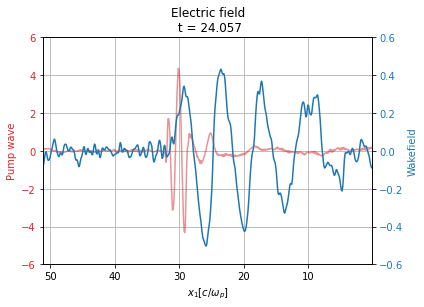

In [5]:
fig, ax1 = plt.subplots()

xmin = sim.emf.dx/2
xmax = sim.emf.box - sim.emf.dx/2

x = np.linspace(xmin, xmax, num = sim.nx)

color = 'tab:red'
ax1.set_xlabel('$x_1 [ c / \omega_p ]$')
ax1.set_ylabel('Pump wave', color=color)
ax1.plot(x, sim.emf.Ey, color=color, alpha = 0.5, label = "pump")
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_xlim([xmax, xmin])
ax1.set_ylim([-6, 6])
ax1.grid(True)

color = 'tab:blue'
ax2 = ax1.twinx()
ax2.set_ylabel('Wakefield', color=color)
ax2.plot(x, sim.emf.Ex, color=color, label = "wakefield")
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_ylim([-0.6, 0.6])

fig.tight_layout()
plt.title("Electric field\n t = {:g}".format(sim.t))
plt.show()

The longitudinal momentum of the particles shows particles oscillating in the wakefield, with some of them being captured by this wave and being accelerated to high energies:

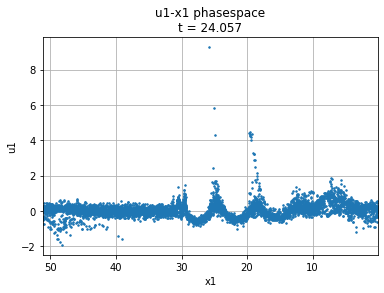

In [6]:
import matplotlib.pyplot as plt

# Simple function to convert particle positions
x = lambda s : (s.particles['ix'] + s.particles['x']) * s.dx 

plt.plot(x(electrons),  electrons.particles['ux'],  '.', ms=3)
plt.xlabel("x1")
plt.ylabel("u1")
plt.title("u1-x1 phasespace\nt = {:g}".format(sim.t))
plt.xlim([xmax, xmin])
plt.grid(True)
plt.show()

A plot of the transverse (y) momentum shows particles oscillating directly in the pump wave field around position $x_1 = 30$.

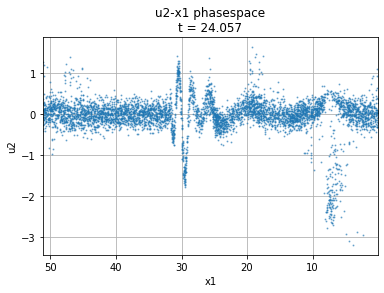

In [7]:
x = lambda s : (s.particles['ix'] + s.particles['x']) * s.dx 

plt.plot(x(electrons), electrons.particles['uy'],  '.', ms=2, alpha = 0.5)
plt.xlabel("x1")
plt.ylabel("u2")
plt.title("u2-x1 phasespace\nt = {:g}".format(sim.t))
plt.xlim([xmax, xmin])
plt.grid(True)
plt.show()

## A more modern approach

Several techniques have been developed since to improve the numerical modeling of what is now known as the laser wakefield accelerator, or LWFA. Since high-intensity short laser pulses are now a reality, the canonical LWFA setup uses a single laser pulse propagating in an underdense plasma.

In the following example we will use ZPIC to model such an accelerator. The laser pulse is started in vaccuum, and then propagates into a plasma with a step like density profile. For this example we chose a plasma density such that $\omega / \omega_p = 10$.

The simulation is run using what is generally referred to as a moving window: the simulation window moves at the speed of light keeping track of the laser pulse and the trailing spatial region. This allows us to model long propagation distances without having to use a very large simulation box. Note that the simulation is still performed in the laboratory frame, we are just moving the region that is covered by the numerical algorithm.

For simplicity we use a cold (0 temperature) plasma background, so no particles from the bulk plasma are expected to be trapped by the wave unless some other effect comes into play. This is closer to what is to be expected in a standard LWFA configuration, where the laser driver also ionizes a background gas creating a low temperature plasma. Hoever, this is different from the Tajima and Dawson paper, where high temperatures were used so that particles had thermal velocities close to the wakefield velocity and could thus be trapped.

In [8]:
import em1d as zpic

dt = 0.019
tmax = 22.8
nx  = 1000
box = 20.0

# Use a step density profile
electrons = zpic.Species( "electrons", -1.0, 16,
                           density = zpic.Density( type = "step", start = 20.0))

# Initialize simulation
sim = zpic.Simulation( nx, box, dt, species = electrons )

# Add laser pulse
sim.add_laser( zpic.Laser( start = 17.0, fwhm = 2.0, a0 = 1.0, omega0 = 10.0, polarization = np.pi/2 ))

# Set moving window
sim.set_moving_window()

# Set current smoothing
sim.set_smooth( zpic.Smooth(xtype = "compensated", xlevel = 4) )

# Run the simulation
sim.run( tmax )


Running simulation up to t = 22.8 ...
n = 1201, t = 22.819
Done.


### Accelerating field

Just as the Tajima and Dawson paper predicted, the laser pulse drives a large amplitude plasma wave behind it (shown in red), that carries a strong longitudinal electric field (blue).

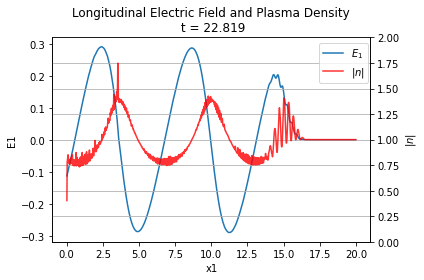

In [9]:
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots()

# Plot values at the center of the cells
xmin = sim.emf.dx/2
xmax = sim.emf.box - sim.emf.dx/2

ax1.plot(np.linspace(xmin, xmax, num = sim.nx), sim.emf.Ex, label = "$E_1$" )
ax1.set_xlabel("x1")
ax1.set_ylabel("E1")

ax2 = ax1.twinx()
ax2.plot(np.linspace(xmin, xmax, num = sim.nx), np.abs(electrons.charge()),'r', label = "$|n|$" , alpha = 0.8)
ax2.set_ylabel("|$n$|")
ax2.set_ylim(0,2)

plt.title("Longitudinal Electric Field and Plasma Density\n t = {:g}".format(sim.t))
plt.grid(True)

fig.legend(loc = (0.75,0.70))
fig.tight_layout()

plt.show()

### Phasespaces

The longitudinal phasespace shows particles oscillating in the laser wakefield. As expected, no particles from the bulk plasma are trapped and accelerated. The streak of particles that can be seen in the left of the plot that are clearly being accelerated come from an oscillation at the front edge of the plasma ocurring when the laser pulse hits it.

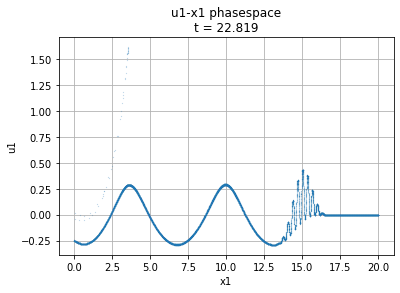

In [10]:
x = lambda s : (s.particles['ix'] + s.particles['x']) * s.dx 

plt.plot(x(electrons),  electrons.particles['ux'],  '.', ms = 0.2)
plt.xlabel("x1")
plt.ylabel("u1")
plt.title("u1-x1 phasespace\nt = {:g}".format(sim.t))
plt.grid(True)
plt.show()

The transverse (y) phasespace shows particle oscillations in the laser field.

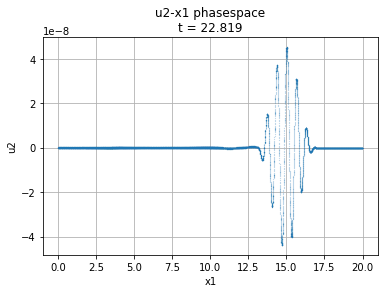

In [11]:
x = lambda s : (s.particles['ix'] + s.particles['x']) * s.dx 

plt.plot(x(electrons),  electrons.particles['uy'],  '.', ms = 0.2)
plt.xlabel("x1")
plt.ylabel("u2")
plt.title("u2-x1 phasespace\nt = {:g}".format(sim.t))
plt.grid(True)
plt.show()

## LWFA in 2D

The advances achieved in computing power mean that we can now simulate the same type of scenario in 2D using a modest laptop computer. The 2D simulation below uses the same setup as described in the previous section, but now using a gaussian beam that is focused at the plasma entrance, with a waist $w_0 = 4$ in simulation units.

This simulation takes only a few seconds to run.

In [12]:
import em2d as zpic
import numpy as np


dt = 0.014
tmax = 22.0;

#Simulation box
nx  = [ 1000, 64 ]
box = [ 20.0, 12.8 ]

electrons = zpic.Species( "electrons", -1.0, [2,2],
                           density = zpic.Density( type = "step", start = 20.0))

# Initialize simulation
sim = zpic.Simulation( nx, box, dt, species = electrons )

# Add laser pulse
sim.add_laser( zpic.Laser( type = "gaussian", start = 17.0, fwhm = 2.0, a0 = 1.0, omega0 = 10.0, 
                           W0 = 4.0, focus = 20.0, axis = 6.4, polarization = np.pi/2 ))


# Set moving window
sim.set_moving_window()

# Set current smoothing
sim.set_smooth( zpic.Smooth(xtype = "compensated", xlevel = 4) )

# Run the simulation
sim.run( tmax )


Running simulation up to t = 22 ...
n = 1572, t = 22.008
Done.


### Accelerating field

The plot below shows the 2D structure of the accelerating wakefield. Transversely the size is similar to that of the laser driver.

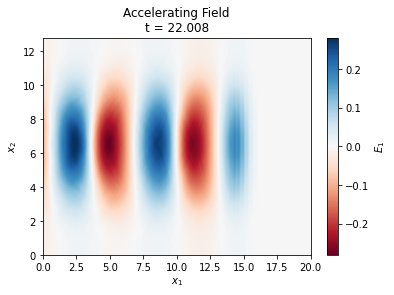

In [13]:
import matplotlib.pyplot as plt

range = [[0,sim.box[0]],[0,sim.box[1]]]

plt.imshow( sim.emf.Ex, interpolation = 'bilinear', origin = 'lower',
          extent = ( range[0][0], range[0][1], range[1][0], range[1][1] ),
          aspect = 'auto', cmap = 'RdBu')

plt.colorbar().set_label('$E_1$')
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.title("Accelerating Field\nt = {:g}".format(sim.t))

plt.show()

### Phasespaces

The longitudinal ($u_x-x$) phasespace shows a very similar behavior to the 2D one. However, since there are many electrons that don't feel the effect of the laser pulse or the wakefield, or feel them to a lesser extent, given that they are away from the laser propagation axis, we also see particles with more limited motion or no motion at all.

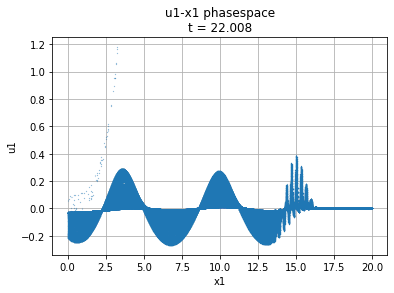

In [14]:
x = lambda s : (s.particles['ix'] + s.particles['x']) * s.dx[0]

plt.plot(x(electrons),  electrons.particles['ux'],  '.', ms = 0.2 )
plt.xlabel("x1")
plt.ylabel("u1")
plt.title("u1-x1 phasespace\nt = {:g}".format(sim.t))
plt.grid(True)
plt.show()